## Simple time integration - the Euler method

In this unit we begin with Newton's second law

$$F = ma$$

and apply it to the problem of a falling body,
$$F = -mg$$

where $m$ is the mass of the body and $g$ = 9.8 $\textrm{m/s}^2$. Assume the body falls along the y-axis, then from the definition of acceleration we know

$$\frac{d^2y}{dt^2} = -g$$

Pause to note that this is called a *second-order ordinary differential equation*. Second order because it is a second derivative, ordinary because the function $y$ is a function of one variable only, $t$ and differential because it relates rates of change through derivatives. This terminology will be important!

The analytic solution to this equation can be arrived at by integrating the equation twice, yielding
$$ \frac{dy}{dt} = v(t) = v(0) -gt$$
$$y(t) = -\frac{1}{2}gt^2 + v(0) t +y(0).$$

You no doubt explored various problems that can be solved with that pair of equations in previous physics classes. They work well. For the sake of this class, and a simple starting point, let us solve these equations *numerically*. The derivatives we are interested in are:

$$\frac{dy}{dt} = v$$ 
$$\frac{dv}{dt} = -g$$

If we recall our calculus, the definition of a derivative is the following:

$$ \lim_{\Delta t \to 0} \frac{y(t+\Delta t) - y(t)}{\Delta t} = v(t)$$ 
$$ \lim_{\Delta t \to 0} \frac{v(t+\Delta t) - v(t)}{\Delta t} = -g(t)$$

If we assume that we can use floating point arithmetic to get a $\Delta t$ sufficiently small, then we can begin treating $\Delta t$ as an algebraic quantity, allowing us to solve the equations for what will happen next, $t+\Delta t$ in terms of now, $t$

$$y(t+\Delta t) = y(t) + v(t) \Delta t$$
$$v(t+\Delta t) = v(t) - g(t) \Delta t$$

Note that we have effectively transformed a second order ordinary differential equation, $\frac{d^2y}{dt^2} = -g$ into a pair of first order differential equations. This method amounts to using information at the beginning of the time interval to assess slopes $v(t)$ and $g(t)$. It is called the *Euler Method* and is a good starting point for studying how ODEs are solved numerically.

### Numerical solution

Now, let us write a general interface to solving such equations. It was helpful to think of Newton's second law in the context of gravity to see the relation between forces and second order ordinary differential equations. However, as we begin to write software, we'd like something more easily generalizable to any system of second order ODEs. We are trying to solve equations of the form

$$\frac{d \mathbf{y}}{dt} = f(\mathbf{y},t)$$

where $\mathbf{y}$ is a vector of values, and $f(\mathbf{y},t)$ returns one value for each $\mathbf{y}$. Specifically, $f(\mathbf{y},t)$ is a function that accepts values of $\mathbf{y}$, and returns their derivatives! If those derivatives do not explicitly depend on $t$, then the system is said to be *autonomous*. For most of our examples, the systems will be *autonomous* or independent of explicit $t$ dependence. Explicit $t$ dependence might occur if there is a motor involved, providing steady, time-dependent force to the system.

We'd like to abstract that $f(\mathbf y,t)$ to be some system of equations, and write a function that uses $f(\mathbf y, t)$ to take the system's state from $y(t)$ to $y(t+\Delta t)$.

### Problem 1

Write a function, called `solve_ode` according to the signature below. While it's rare that I'm so pedantic about the required interface to your solutions, you will later learn that if you do it this way, moving to the pre-written ODE solvers will be much easier. The challenging portions are to proper use of function handles, including the function handle for the keyword `method` and the use of `*args` and `**options` (or, often `**kwargs`). Consult Python documentation if you are not familiar with these features of the language, quickly:

```
*args → "extra positional arguments become a tuple"
**kwargs → "extra keyword arguments become a dict"
```

Finally observe that data will have to be managed internally, and that lists are well suited to the task. However, they will often have to be converted to `numpy arrays` upon return from the function, depending on the post-processing that is needed.

*in-class* - discuss the following solver with your group and come up with implementation plans. Be especially conscience of the `*args`, `**options`, function handles, and modes of storing data within a central loop over time.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def Euler(dt, f, t, y, args):
    return y + f(t,y,*args) * dt 

def EulerCromer(dt, f, t, y, args): #go full step forward and sample that for interval
    y_end = y + f(t,y,*args) * dt
    return y + f(t+dt,y_end,*args) * dt


def EulerRichardson(dt, f, t, y, args): #Midpoint sampling
    y_mid = y + f(t, y, *args) * (dt / 2) #Gives us the velocity at the midpoint
    return y + f(t + dt/2, y_mid, *args) * dt #We calculate overall difference using midpoint velocity. y + velocity at midpoint * dt


def solve_ode(f,tspan, y0, method = Euler, *args, **options):
    """
    Given a function f that returns derivatives,
    dy / dt = f(t, y)
    and an inital state:
    y(tspan[0]) = y0
    
    This function will return the set of intermediate states of y
    from t0 (tspan[0]) to tf (tspan[1])
    
    
    
    The function is called as follows:
    
    INPUTS 
    
    f - the function handle to the function that returns derivatives of the 
        vector y at time t. The function can also accept parameters that are
        passed via *args, eg f(t,y,g) could accept the acceleration due to gravity.
        
    tspan - a indexed data type that has [t0 tf] as its two members. 
            t0 is the initial time
            tf is the final time
    
    y0 - The initial state of the system, must be passed as a numpy array.
    
    method - The method of integrating the ODEs. This week will be one of Euler, 
             Euler-Cromer, or Euler-Richardson
    
    *args - extra positional arguments that become a tuple containing 
        additional parameters you would like for the function handle f.
    
    **options - keyword arguments that become a dictionary containing 
                the keywords that might be used to control function behavior. 
                For now, there is only one:
                
                first_step - the initial time step for the simulation.
    
    
    OUTPUTS
    
    t,y
    
    The returned states will be in the form of a numpy array
    t containing the times the ODEs were solved at and an array
    y with shape tsteps,N_y where tsteps is the number of steps 
    and N_y is the number of equations
    
    """

    y = []
    y.append(y0)
    
    t=[]
    t.append(0)
    
    dt = options.get('first_step',0.1)
    numsteps = int(tspan/dt)
    
    if method not in [Euler, EulerCromer,EulerRichardson]:
        raise ValueError("Unknown function")
    
    for i in range(1,numsteps):
        t.append(i*dt)
        y.append(method(dt,f,t[i-1],y[i-1],args))
        
    return np.array(y), np.array(t)

    # Write the code that initializes the lists to hold y and t,
    # sets the initial conditions and time step, checks that the method is known,
    # then loops over all time steps to get the updated states and times, placing
    # them in lists. Finally, return the arrays specified in the function's documentation, 
    # above.
    

### Problem 2

Now implement the ODEs at the beginning of this discussion,

$$\frac{dy}{dt} = v$$ and,
$$\frac{dv}{dt} = -g$$

where $g$ is 9.8 $\frac{m}{s^2}$. These physics should enter as a function called `falling_body(t,y,g)`. 

Integrate this function using the Euler method. Use $\mathbf{y}_0 = (y_0,v_0) = (3,0)$. Begin at $t_0$= 0, and end at time $t_f=\sqrt{\frac{6}{g}}$. Plot your results. Label the axes with titles and appropriate units.



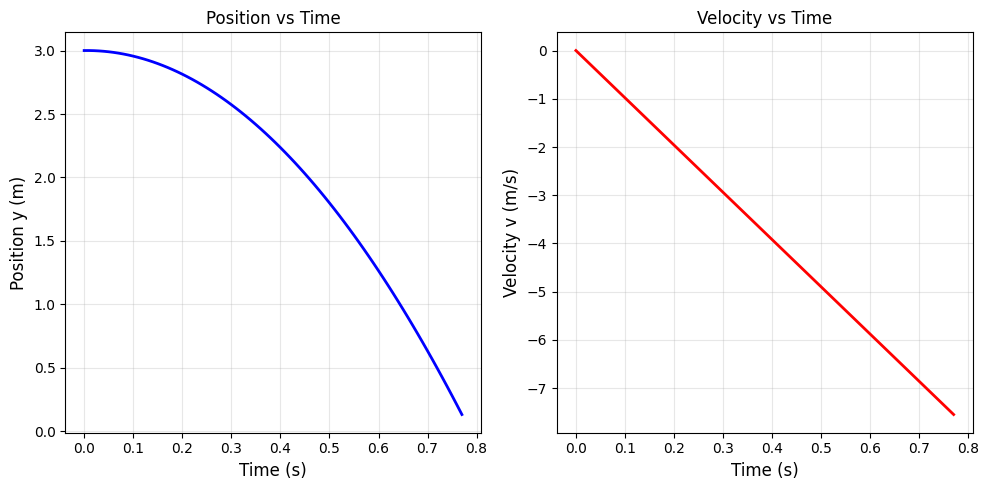

In [83]:
def simple_gravity(t,y,g=9.8):
    """
    This describes the ODEs for the kinematic equations:
    dy/dt =  v
    dv/dt = -g
    """
    return np.array([y[1],-1*g])
    
g=9.8
t_f = (6/g)**0.5
y,t = solve_ode(simple_gravity,t_f,[3,0],method=Euler,first_step=0.01)


# Plot the results
plt.figure(figsize=(10, 5))

# Plot position vs time
plt.subplot(1, 2, 1)
plt.plot(t, y[:, 0], 'b-', linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title('Position vs Time', fontsize=12)
plt.grid(True, alpha=0.3)

# Plot velocity vs time
plt.subplot(1, 2, 2)
plt.plot(t, y[:, 1], 'r-', linewidth=2)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity v (m/s)', fontsize=12)
plt.title('Velocity vs Time', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Problem 3

*In class* - think about and see if you can think of ways of improving upon the Euler method. Be sure to discuss the core function of what Euler is doing and where it is doing it.

Now add the Euler Cromer and Euler Richardson methods for integrating the ODEs. The methods are to evaluate slopes at the beginning of the time interval, Euler, evaluating the slopes at the end of the interval, Euler Cromer, and evaluating slopes at the middle of the interval, Euler Richardson.

#### Euler Method

Slopes at the beginning:

$$y(t+\Delta t) = y(t) + \frac{dy}{dt}(t,y)\Delta t$$

#### Euler Cromer Method

Slopes at the end:

$$y_{end} = y(t) + \frac{dy}{dt}(t,y) \Delta t$$
$$y(t+\Delta t) = y(t) + \frac{dy}{dt}(t+\Delta t,y_{end}) \Delta t$$


**Note -** *a small improvement for some systems can be achieved by first finding the new postion using an Euler step,starting at time $t$ and then using the result of this to find the update to the velocity, using position $y(t+\Delta t)$. This is probably the true intent of the algorithm, but that makes the algorithm too specialized, so we'll use the formula above.*

#### Euler Richardson Method
Slopes in the middle:

$$y_{mid} = y(t) + \frac{dy}{dt}(t,y) \frac{\Delta t}{2}$$
$$y(t+\Delta t) = y(t) +  \frac{dy}{dt}(t+\frac{\Delta t}{2},y_{mid}) \Delta t$$

### Problem 4

Use the newly implemented algorithms to redo the falling body simulation. Plot all three on the same axes and create a legend. Explore how differences in accuracy are seen as $\Delta t$ is varied. What $\Delta t$ is required for good results for each of the three algorithms? For comparison and calculation of error, use the analytic solution

$$y(t) = -\frac{1}{2}gt^2+v_0t+y_0.$$


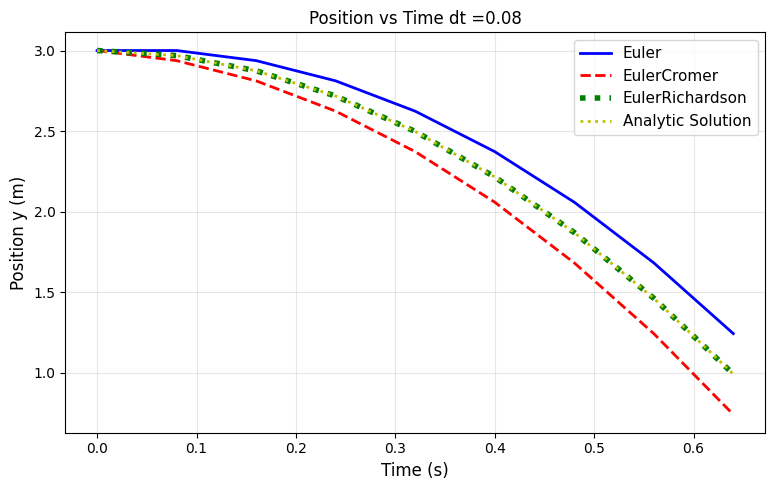

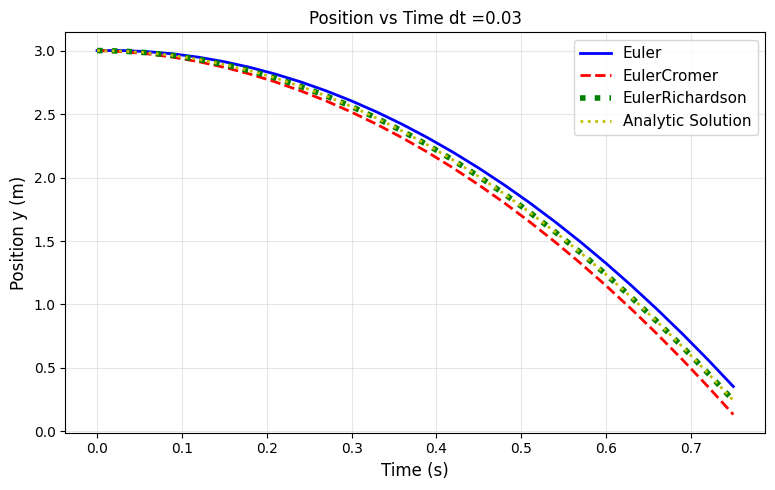

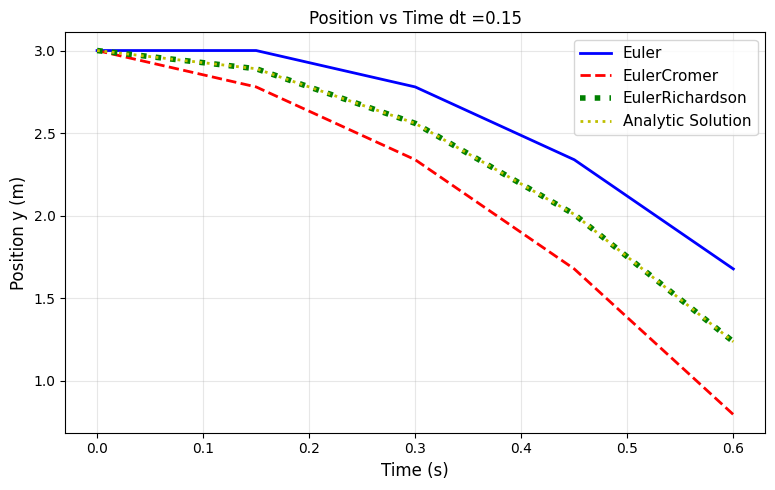

In [84]:

def analytic_solution(y,t_f,dt,g=9.8):
    #y is 2 length array with initial position,initial velocity
    pos = []
    time = []
    numsteps = int(t_f/dt)
    for i in range(numsteps):
        t = i*dt
        time.append(t)
        pos.append(-(1/2)*g*(t**2)+y[1]*t+y[0])
        
    return np.array(pos),np.array(time)

dt = .08

y0,t0 = solve_ode(simple_gravity,t_f,[3,0],method=Euler,first_step=dt)
y1,t1 = solve_ode(simple_gravity,t_f,[3,0],method=EulerCromer,first_step=dt)
y2,t2 = solve_ode(simple_gravity,t_f,[3,0],method=EulerRichardson,first_step=dt)

y3,t3 = analytic_solution([3,0],t_f,dt)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot position vs time - all three methods
plt.subplot(1, 2, 1)
plt.plot(t0, y0[:, 0], 'b-', linewidth=2, label='Euler')
plt.plot(t1, y1[:, 0], 'r--', linewidth=2, label='EulerCromer')
plt.plot(t2, y2[:, 0], 'g:', linewidth=4, label='EulerRichardson')
plt.plot(t3, y3, 'y:', linewidth=2, label='Analytic Solution')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title(f'Position vs Time dt ={dt}', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

dt = .03

y0,t0 = solve_ode(simple_gravity,t_f,[3,0],method=Euler,first_step=dt)
y1,t1 = solve_ode(simple_gravity,t_f,[3,0],method=EulerCromer,first_step=dt)
y2,t2 = solve_ode(simple_gravity,t_f,[3,0],method=EulerRichardson,first_step=dt)

y3,t3 = analytic_solution([3,0],t_f,dt)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot position vs time - all three methods
plt.subplot(1, 2, 1)
plt.plot(t0, y0[:, 0], 'b-', linewidth=2, label='Euler')
plt.plot(t1, y1[:, 0], 'r--', linewidth=2, label='EulerCromer')
plt.plot(t2, y2[:, 0], 'g:', linewidth=4, label='EulerRichardson')
plt.plot(t3, y3, 'y:', linewidth=2, label='Analytic Solution')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title(f'Position vs Time dt ={dt}', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

dt = .15

y0,t0 = solve_ode(simple_gravity,t_f,[3,0],method=Euler,first_step=dt)
y1,t1 = solve_ode(simple_gravity,t_f,[3,0],method=EulerCromer,first_step=dt)
y2,t2 = solve_ode(simple_gravity,t_f,[3,0],method=EulerRichardson,first_step=dt)

y3,t3 = analytic_solution([3,0],t_f,dt)

# Plot the results
plt.figure(figsize=(15, 5))

# Plot position vs time - all three methods
plt.subplot(1, 2, 1)
plt.plot(t0, y0[:, 0], 'b-', linewidth=2, label='Euler')
plt.plot(t1, y1[:, 0], 'r--', linewidth=2, label='EulerCromer')
plt.plot(t2, y2[:, 0], 'g:', linewidth=4, label='EulerRichardson')
plt.plot(t3, y3, 'y:', linewidth=2, label='Analytic Solution')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title(f'Position vs Time dt ={dt}', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Problem 5 

Find the slope of the curve that results when plotting error vs. $\Delta t$. Use the `loglog` function to do the plotting. Refer back to the lecture onf finding exponents to do this type of plot and curve fitting. We are looking for the exponent in the relationship 

$$\textrm{error} \propto \Delta t^{\alpha}$$

Before carying out this exercise, make sure you know what a desirable $\alpha$ is vs. an undesirable $\alpha$.

Make sure to find the errors for a large range of $\Delta t$s. I suggest you become familiar with the `logspace` function in `numpy`.

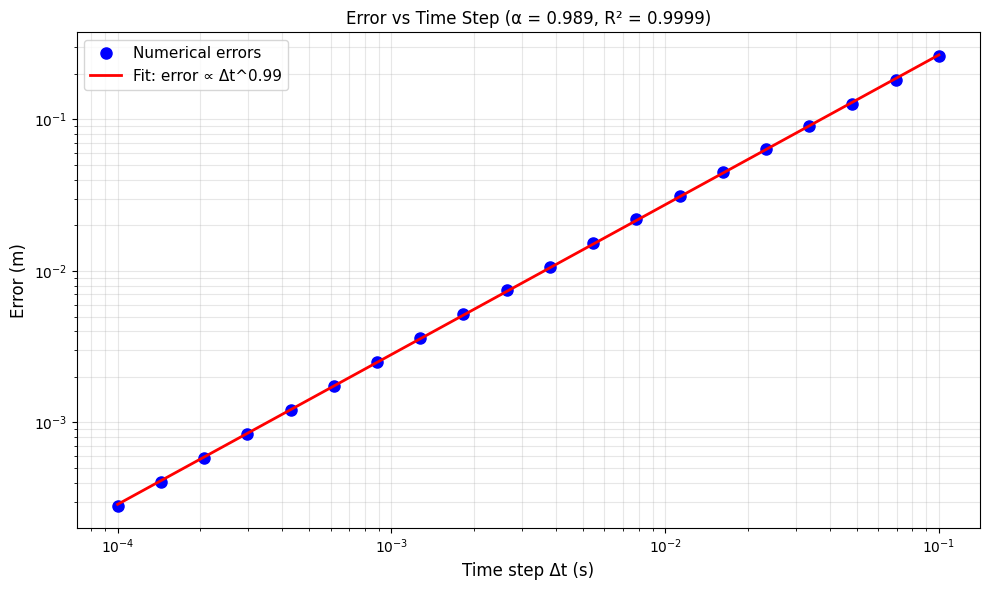

Euler method exponent α = 0.989
Desirable α > 1 (error decreases faster with smaller Δt)


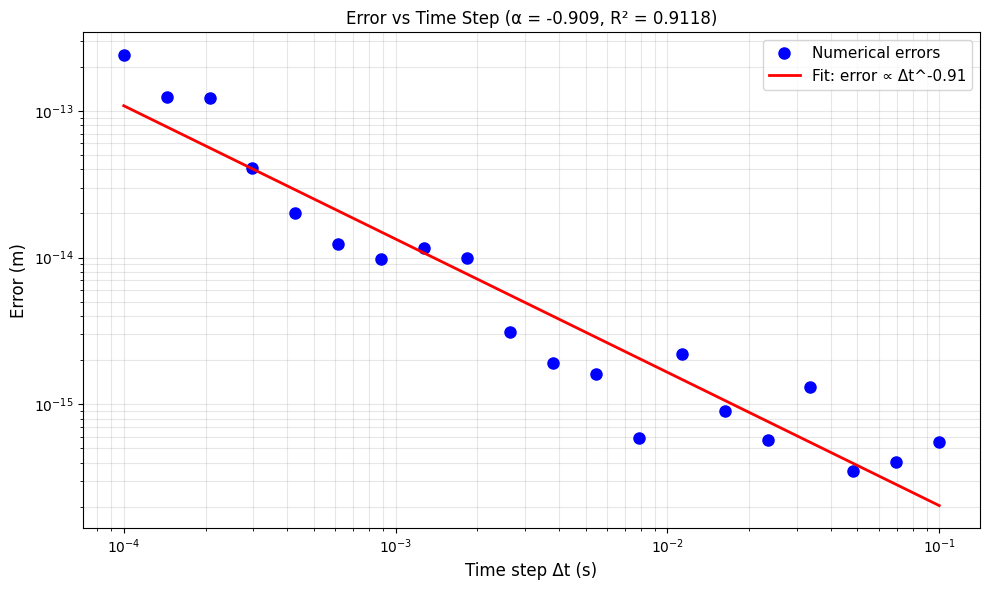

Euler Richardson method exponent α = -0.909


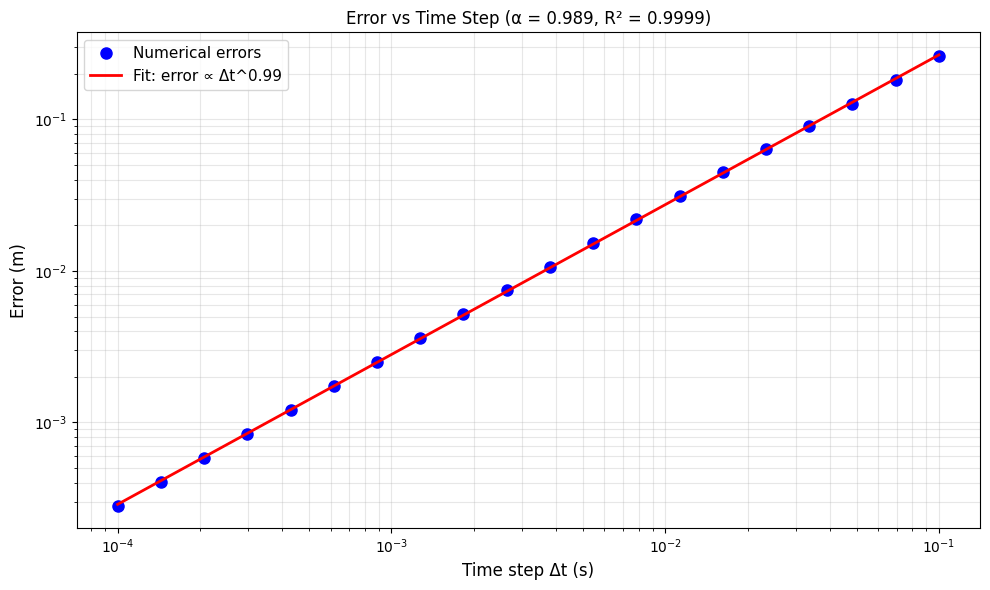

Euler Cromer method exponent α = 0.989
We should expect Euler Richardson to have α ~= 2, but we are getting absurdly small errors. Some research indicated this may be a floating point issue.


In [85]:
from scipy.stats import linregress

def error(y,y_a):
    """
    Simple convenience to compute errors between y and y_a
    the numerical (y) and the analytic solution (y_a)
    Use a L2 norm or just a sum of the squares of differences
    """
    #Root mean squared error between two data sets
    if len(y) != len(y_a):
        raise ValueError(f"Length mismatch: len(y)={len(y)}, len(y_a)={len(y_a)}")

    #L2 Norm
    #return np.sum((y-y_a)**2)
    #RMSE
    return np.sqrt(np.mean((y - y_a)**2))

def error_scale(steps,errors,plot=True):
    
    """
    INPUTS - 
        steps = a vector of the steps, this will be better if they are logspaced
        errors = a vector errors, usually |y - y_analytic|
        plot = a boolean telling the method to plot, or not
    """
    
    log_steps = np.log10(steps)
    log_errors = np.log10(errors)
    
    slope, intercept, r_value, p, std_error = linregress(log_steps,log_errors)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.loglog(steps, errors, 'bo', markersize=8, label='Numerical errors')
        
        # Plot the fitted line
        fitted_errors = 10**(intercept + slope * log_steps)
        plt.loglog(steps, fitted_errors, 'r-', linewidth=2, 
                   label=f'Fit: error ∝ Δt^{slope:.2f}')
        
        plt.xlabel('Time step Δt (s)', fontsize=12)
        plt.ylabel('Error (m)', fontsize=12)
        plt.title(f'Error vs Time Step (α = {slope:.3f}, R² = {r_value**2:.4f})', fontsize=12)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, which='both')
        plt.tight_layout()
        plt.show()
    
    return slope, intercept

# Generate errors for a range of time steps using various methods
dts = np.logspace(-1, -4, 20)  # 20 time steps from 0.1 to 0.0001
initial_y = 3
initial_vy = 0
t_f = 1

 
errors_euler = []
errors_euler_richardson = []
errors_euler_cromer = []

for dt in dts:
    euler_num, t_num = solve_ode(simple_gravity, t_f, [initial_y, initial_vy], method=Euler, first_step=dt)
    euler_richardson_num, t_num = solve_ode(simple_gravity, t_f, [initial_y, initial_vy], method=EulerRichardson, first_step=dt)
    euler_cromer_num, t_num = solve_ode(simple_gravity, t_f, [initial_y, initial_vy], method=EulerCromer, first_step=dt)
    
    y_ana, t_ana = analytic_solution([initial_y, initial_vy], t_f, dt)
    
    errors_euler.append(error(euler_num[:, 0], y_ana)) # type: ignore
    errors_euler_richardson.append(error(euler_richardson_num[:, 0], y_ana)) # type: ignore
    errors_euler_cromer.append(error(euler_cromer_num[:, 0], y_ana)) # type: ignore


# Find the slope
slope_euler, _ = error_scale(dts, np.array(errors_euler), plot=True)
print(f"Euler method exponent α = {slope_euler:.3f}")
print(f"Desirable α > 1 (error decreases faster with smaller Δt)")

slope_euler_richardson, _ = error_scale(dts, np.array(errors_euler_richardson), plot=True)
print(f"Euler Richardson method exponent α = {slope_euler_richardson:.3f}")

slope_euler_cromer, _ = error_scale(dts, np.array(errors_euler_cromer), plot=True)
print(f"Euler Cromer method exponent α = {slope_euler_cromer:.3f}")

print("We should expect Euler Richardson to have α ~= 2, but we are getting absurdly small errors. Some research indicated this may be a floating point issue.")





### Problem 6

Finally, implement the function describing simple harmonic motion. This is determined from the following equations

$$ \frac{d^2y}{dt^2} = -\frac{k}{m} y $$

Use $k=1$, $m = 1$, $y_0 = .5$, $t_0=0$, $t_f=2\pi \cdot 4$.

Follow the procedure used above: first plot position vs. time for each of the three algorithms, then plot the errors as a function of the time step. Are there differences in the errors? Where, how, what? The analytic solution for this system is:

$$ \omega_0 = \sqrt{\frac{k}{m}}$$

$$ y(t) = y_0 \cos(\omega_0 t) + \frac{v_0}{\omega_0} \sin(\omega_0 t) $$

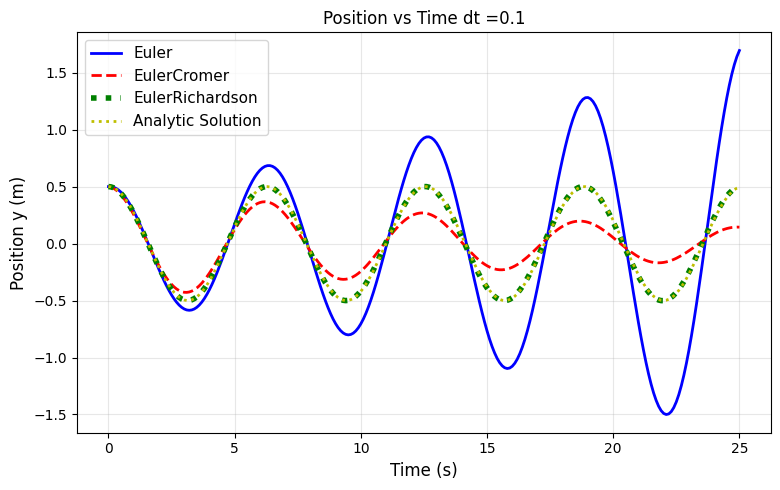

In [ ]:
import math


def sho(t,y,k=1):
    """
    The simple harmonic oscillator
    dy/dt = v
    dv/dt = -k/m y
    """
    return np.array([y[1],-k*y[0]])

def sho_analytic(k,m,y0,v0,tf,dt):
    pos = []
    time = []
    numsteps = int(tf/dt)
    
    w = np.sqrt(k/m)
    
    for i in range(numsteps):
        t=i*dt
        time.append(t)
        
        pos.append(y0*np.cos(w*t)+(v0/w)*np.sin(w*t))
        
    return np.array(pos),np.array(time)

# Plot 

k = 1
m=1
y0 = .5
t_f = 2*math.pi*4
y=[y0,0]
dt=0.1

y0,t0 = solve_ode(sho,t_f,y,method=Euler,first_step=dt)
y1,t1 = solve_ode(sho,t_f,y,method=EulerCromer,first_step=dt)
y2,t2 = solve_ode(sho,t_f,y,method=EulerRichardson,first_step=dt)

y3,t3 = sho_analytic(k,m,y[0],y[1],t_f,dt)


# Plot the results
plt.figure(figsize=(15, 5))

# Plot position vs time - all three methods
plt.plot(t0, y0[:, 0], 'b-', linewidth=2, label='Euler')
plt.plot(t1, y1[:, 0], 'r--', linewidth=2, label='EulerCromer')
plt.plot(t2, y2[:, 0], 'g:', linewidth=4, label='EulerRichardson')
plt.plot(t3, y3, 'y:', linewidth=2, label='Analytic Solution')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Position y (m)', fontsize=12)
plt.title(f'Position vs Time dt ={dt}', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


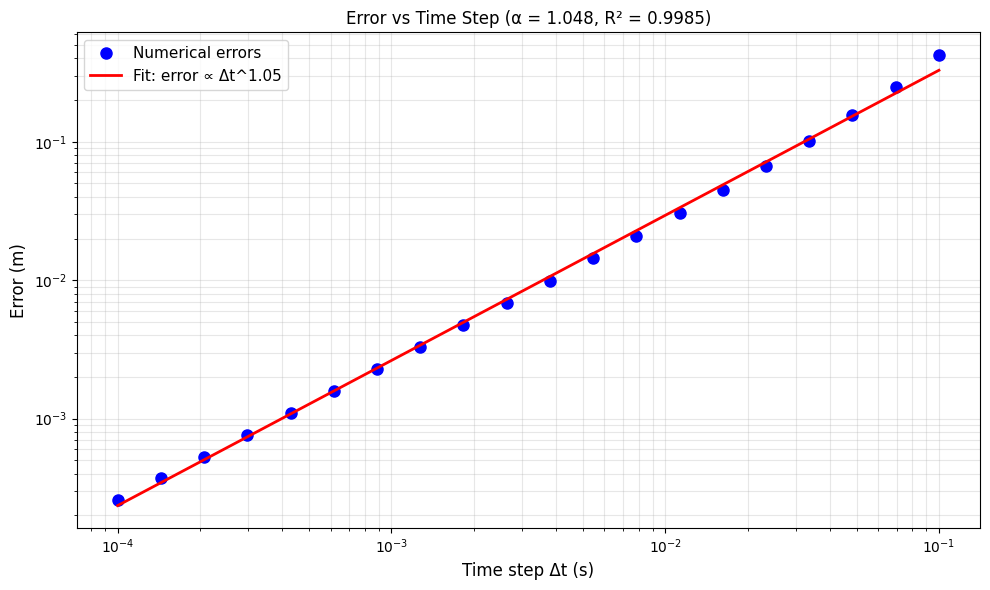

Euler method exponent α = 1.048
Desirable α > 1 (error decreases faster with smaller Δt)


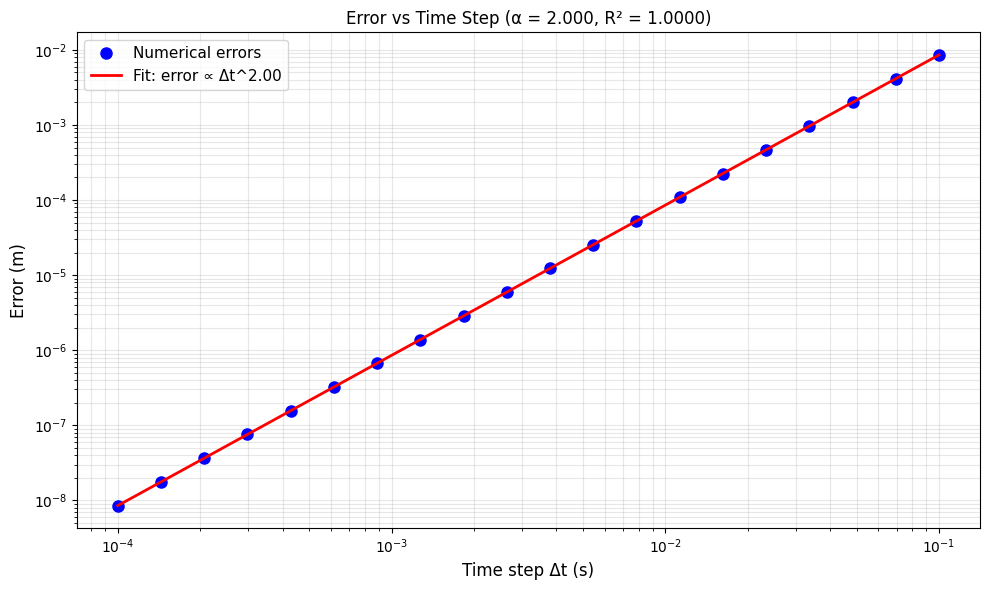

Euler Richardson method exponent α = 2.000


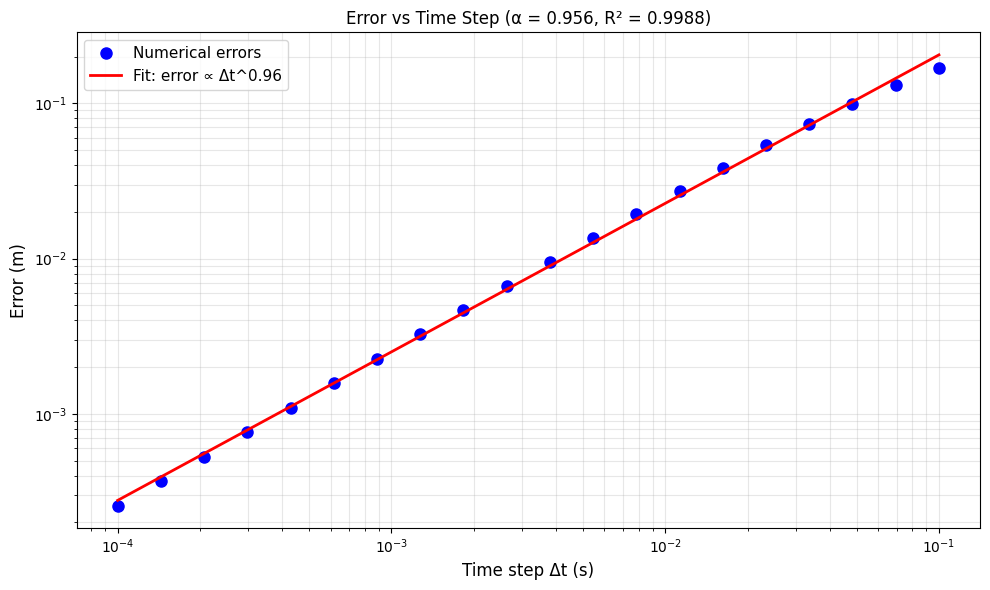

Euler Cromer method exponent α = 0.956


In [ ]:
# Conduct the complete error analysis

# Generate errors for a range of time steps using various methods
dts = np.logspace(-1, -4, 20)  # 20 time steps from 0.1 to 0.0001
initial_y = .5
initial_vy = 0
t_f = 2*math.pi*4

 
errors_euler = []
errors_euler_richardson = []
errors_euler_cromer = []

for dt in dts:
    euler_num, t_num = solve_ode(sho, t_f, [initial_y, initial_vy], method=Euler, first_step=dt)
    euler_richardson_num, t_num = solve_ode(sho, t_f, [initial_y, initial_vy], method=EulerRichardson, first_step=dt)
    euler_cromer_num, t_num = solve_ode(sho, t_f, [initial_y, initial_vy], method=EulerCromer, first_step=dt)
    
    y_ana, t_ana = sho_analytic(1,1,initial_y,initial_vy,t_f,dt)
    
    errors_euler.append(error(euler_num[:, 0], y_ana)) # type: ignore
    errors_euler_richardson.append(error(euler_richardson_num[:, 0], y_ana)) # type: ignore
    errors_euler_cromer.append(error(euler_cromer_num[:, 0], y_ana)) # type: ignore


# Find the slope
slope_euler, _ = error_scale(dts, np.array(errors_euler), plot=True)
print(f"Euler method exponent α = {slope_euler:.3f}")

slope_euler_richardson, _ = error_scale(dts, np.array(errors_euler_richardson), plot=True)
print(f"Euler Richardson method exponent α = {slope_euler_richardson:.3f}")

slope_euler_cromer, _ = error_scale(dts, np.array(errors_euler_cromer), plot=True)
print(f"Euler Cromer method exponent α = {slope_euler_cromer:.3f}")